Notebook for training BERT classifier

## Setup
- Copy into the notebook the training.csv and testing.csv data


## Load Data
- Set DROP_SOCIAL_PRESSURE to True if you are removing those labels

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)

path_to_training = 'training.csv'
path_to_testing  = 'testing.csv'

drop_social_pressure = False # If you want to remove the social and pressure tags
concat=True

"""This concatinates the training.csv/testing.csv training.csv was annotated by
phd students and testing.csv was annotated by the project team. I believe we
annotated different data but I need to double check"""

test_size=0.2 # If concaenating u can choose sklearn test split with this
verbose = True

def import_data(path_to_training,
                path_to_testing,
                drop_social_pressure=None,
                concat=None,
                verbose=None,
                test_size=0.2):

  if concat:
    df = pd.concat([pd.read_csv(path_to_training),
                    pd.read_csv(path_to_testing)]).drop_duplicates()

    train_df, test_df = train_test_split(
      df, test_size=test_size, shuffle=True, random_state=42)

  else:
    train_df = pd.read_csv(path_to_training)
    test_df = pd.read_csv(path_to_testing)

  if drop_social_pressure:
    train_df=train_df.drop(columns=['6-SOCIAL', '7-PRESSURE'])
    test_df = test_df.drop(columns=['6-SOCIAL', '7-PRESSURE'])

  label_columns = train_df.columns[1:].tolist()

  if verbose:
    print(f'Num Training {len(train_df)}')
    print(f'Num Evaluation {len(test_df)}')

  return train_df, test_df, label_columns

train_df, test_df, label_columns = import_data(
    path_to_training, path_to_testing, drop_social_pressure, concat, verbose)


Num Training 5999
Num Evaluation 1500


## Visualise Tag Distribution

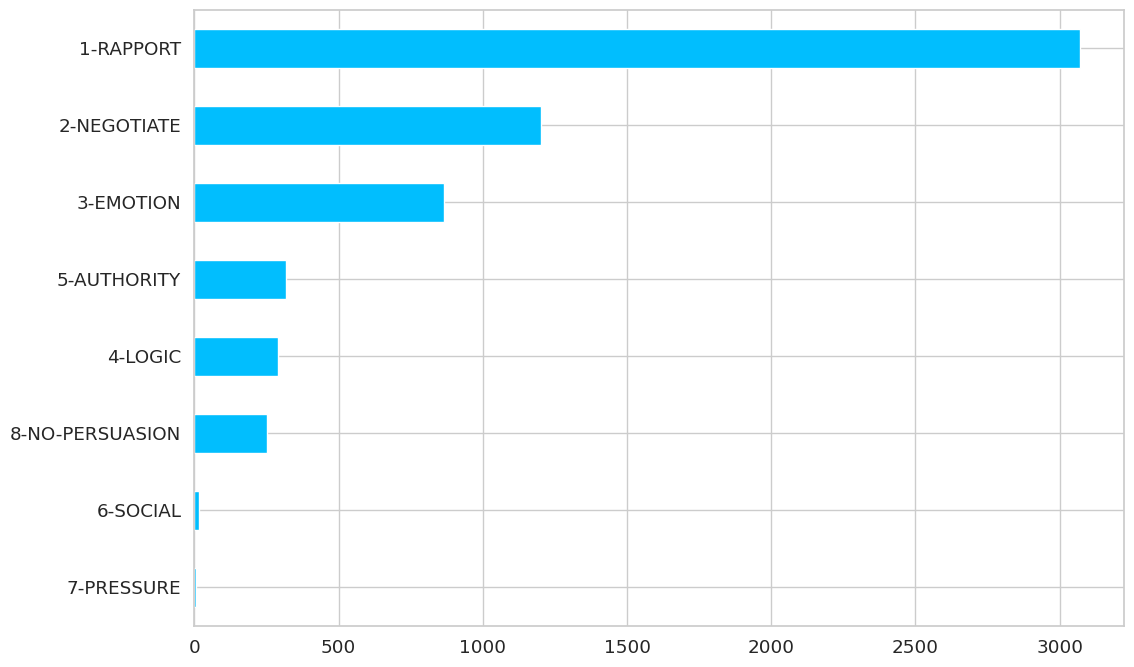

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

train_df[label_columns].sum().sort_values().plot(kind="barh");

## Init BERT Stuff
1. Set mex token count by visualising token distrubtions

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

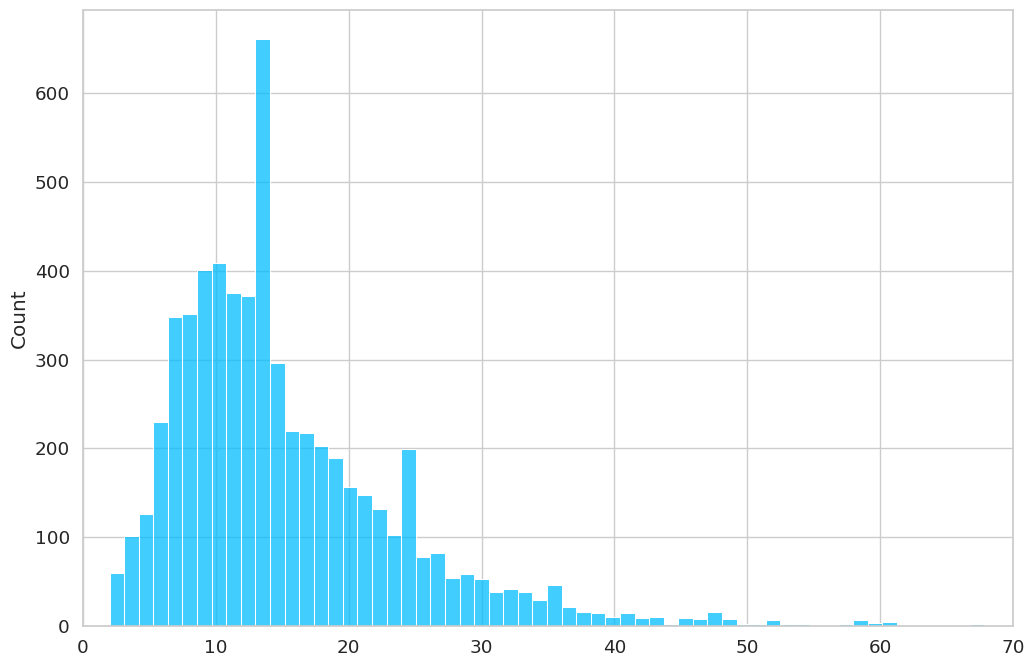

In [ ]:
from transformers import AutoTokenizer, AutoModel

BERT_MODEL_NAME = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

def visualise_tokencounts(df, column_name, max_tokens):

    token_counts = []

    for _, row in df.iterrows():

        token_count = len(tokenizer.encode(
        row[column_name],
        max_length=max_tokens+50,
        truncation=True

      ))

        token_counts.append(token_count)
    sns.histplot(token_counts)
    plt.xlim([0, max_tokens]);

visualise_tokencounts(train_df, 'text', 70)

In [ ]:
MAX_TOKEN_COUNT = 70 # Set Max token. Larger token count will lead to more padding for shorter sequences

## Build DataLoaders

In [ ]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch

class PersuasionStrategyDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: AutoTokenizer,
        max_token_len: int = MAX_TOKEN_COUNT
        ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
        self.LABEL_COLUMNS = data.columns.tolist()[1:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):

        data_row = self.data.iloc[index]
        comment_text = data_row.text
        labels = data_row[self.LABEL_COLUMNS]
        encoding = self.tokenizer.encode_plus(
          comment_text,
          add_special_tokens=True,
          max_length=self.max_token_len,
          return_token_type_ids=False,
          padding="max_length",
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return dict(
          comment_text=comment_text,
          input_ids=encoding["input_ids"].flatten(),
          attention_mask=encoding["attention_mask"].flatten(),
          labels=torch.FloatTensor(labels)
        )

## Add WeightedSampler

In [ ]:
from collections import Counter

def build_sampler(training_dataset):
  labels = [torch.argmax(label['labels']).item() for label in training_dataset]  # Assuming your dataset returns (input_vector, label) pairs
  class_distribution = Counter(labels)

  # Calculate weights for each sample
  class_weights = {class_label: len(training_dataset) / (len(class_distribution) * class_count) for class_label, class_count in class_distribution.items()}
  weights = [class_weights[label] for label in labels]

  # Convert weights to tensor
  weights_tensor = torch.tensor(weights, dtype=torch.float)

  # Create a sampler to balance the dataset during training
  sampler = WeightedRandomSampler(weights_tensor, len(weights_tensor))
  return sampler

In [ ]:
sampler=True # Choose to use weighted sampler

training_dataset = PersuasionStrategyDataset(
    train_df,
    tokenizer
)

if sampler:
  print('Building Sampler')
  sampler = build_sampler(training_dataset)

training_dataloader = DataLoader(
    training_dataset,
    batch_size=64,
    sampler=sampler
)

Building Sampler


## Model Architecture

In [ ]:
import torch.nn as nn

# Load pre-trained BERT model and tokenizer

class BertClassifier(nn.Module):

    """
    BERT-based classifier model.

    Args:
        bert_model (str): The pre-trained BERT model to use.
        num_labels (int): The number of output labels.

    Attributes:
        bert (BertModel): The BERT model.
        dropout (nn.Dropout): Dropout layer for regularization.
        classifier (nn.Linear): Linear layer for classification.

    """

    def __init__(self, name, bert_model, num_labels):
        super(BertClassifier, self).__init__()
        self.name = name
        self.bert = AutoModel.from_pretrained(bert_model)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):

        """
        Forward pass of the BERT classifier.

        Args:
            input_ids (torch.Tensor): The input token IDs.
            attention_mask (torch.Tensor): The attention mask.

        Returns:
            torch.Tensor: The logits for each class.

        """
        if self.name == 'bert':
            outputs = self.bert(input_ids=input_ids,
                                attention_mask=attention_mask)
            pooled_output = outputs.pooler_output

        elif self.name == 'distilbert':
            outputs = self.bert(input_ids=input_ids,
                                attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
        else:
            raise ValueError("Invalid model name")

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

## Set hyperparameters

In [ ]:
from torch.optim import lr_scheduler
from tqdm.auto import tqdm


device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 10
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for multilabel classification

model = BertClassifier('distilbert', BERT_MODEL_NAME, len(label_columns))
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## TRAIN!

In [ ]:
def train_model(
        model, training_dataloader, num_epochs, device, optimizer, criterion):

    avg_loss = 0

    model.train()

    with tqdm(range(num_epochs), desc='Average Epoch Loss: ') as t:
        for e in range(num_epochs):
            epoch_loss = []

            with tqdm(range(len(training_dataloader)), desc='Loss: 0') as t2:
                for b, batch in enumerate(training_dataloader):

                    optimizer.zero_grad()

                    if model.name == 'rnn':
                        input_ids = batch['input_ids'].to(device)
                        labels = batch['labels'].to(device)
                        embeddings = model.embd(input_ids)
                        outputs = model(embeddings)

                    elif model.name in ['bert', 'distilbert']:
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        labels = batch['labels'].to(device)
                        outputs = model(input_ids, attention_mask)

                    loss = criterion(outputs, labels.float())
                    epoch_loss.append(loss.item())
                    loss.backward()
                    optimizer.step()

                    avg_epoch_loss = round(sum(epoch_loss)/len(epoch_loss), 4)
                    description = f'Epoch: {e} | '
                    description += f'Batch {b} | '
                    description += f'Average Loss: {avg_epoch_loss}'

                    t2.set_description(description)
                    t2.update()

            t.set_description(
                f'Average Epoch Loss: {round(sum(epoch_loss)/len(epoch_loss),4)}')
            t.update()

    return avg_loss, model

In [ ]:
avg_loss, model = train_model(
    model, training_dataloader, num_epochs, device, optimizer, criterion)

Average Epoch Loss:   0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/94 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/94 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/94 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/94 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/94 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/94 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/94 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/94 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/94 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
val_dataset = PersuasionStrategyDataset(
    test_df,
    tokenizer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32
)

In [ ]:
def eval_model(model, eval_loader, device):
    """
    Evaluate the performance of a model on the evaluation data.

    Args:
        model (torch.nn.Module): The model to evaluate.
        eval_loader (torch.utils.data.DataLoader): The data loader for
        the evaluation data.
        device (torch.device): The device to run the evaluation on.

    Returns:
        tuple: A tuple containing the true labels and predicted labels.
    """

    true_labels = []
    predicted_labels = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(eval_loader):

            if model.name == 'rnn':
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                embeddings = model.embd(input_ids)
                outputs = model(embeddings)
            else:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)

            predicted_probs = torch.sigmoid(outputs)
            predicted_labels.extend(predicted_probs.cpu().numpy() > 0.4)
            true_labels.extend(labels.cpu().numpy())

    return true_labels, predicted_labels

In [ ]:
true_labels, predicted_labels = eval_model(model, val_loader, device)

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels,average='weighted', zero_division=True) # Assuming multilabel
recall = recall_score(true_labels, predicted_labels, average='weighted',zero_division=True)  # Assuming multilabel
f1 = f1_score(true_labels, predicted_labels, average='weighted',zero_division=True)  # Assuming multilabel

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.756
Precision: 0.773100332401555
Recall: 0.7774816788807462
F1 Score: 0.7731499136819752


In [ ]:
report = classification_report(
    true_labels, predicted_labels,
    target_names=label_columns,
    zero_division=True)  # label_names is a list of class names

print(report)

                 precision    recall  f1-score   support

      1-RAPPORT       0.88      0.83      0.85       755
    2-NEGOTIATE       0.80      0.87      0.83       300
      3-EMOTION       0.64      0.78      0.70       225
        4-LOGIC       0.29      0.21      0.24        77
    5-AUTHORITY       0.66      0.74      0.70        77
       6-SOCIAL       0.00      0.00      0.00         3
     7-PRESSURE       1.00      1.00      1.00         0
8-NO-PERSUASION       0.52      0.55      0.53        64

      micro avg       0.77      0.78      0.78      1501
      macro avg       0.60      0.62      0.61      1501
   weighted avg       0.77      0.78      0.77      1501
    samples avg       0.78      0.78      0.77      1501



In [ ]:
# Assuming your trained model is named 'model' and you want to save it to a file named 'model.pth'
torch.save(model.state_dict(), './bert_base_all_10epo.pth')


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


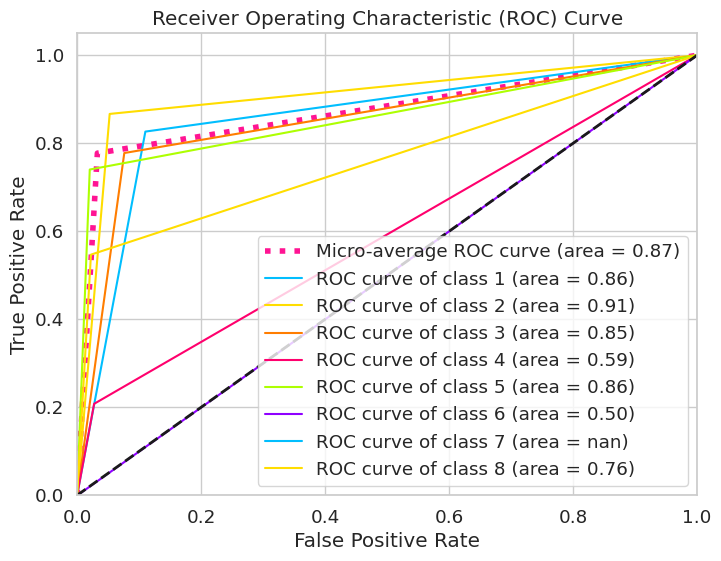

In [ ]:
all_predictions_int = np.array(predicted_labels).astype(int)

LABEL_COLUMNS = training_dataloader.dataset.LABEL_COLUMNS

fpr = dict()
tpr = dict()
roc_auc = dict()

true_labels = np.array(true_labels).astype(int)
for i in range(len(LABEL_COLUMNS)):  # num_classes is the number of classes
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], all_predictions_int[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(true_labels.ravel(), all_predictions_int.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc_micro), color='deeppink', linestyle=':', linewidth=4)

for i in range(len(LABEL_COLUMNS)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
plt.savefig('./bert-base-all_aucroc.png')

<Figure size 1200x800 with 0 Axes>

In [ ]:
with open('./bert-base-all.txt', 'w') as file:
  file.write(report)

In [ ]:
!mkdir /content/bert_base_all/


In [ ]:
! zip -r bert_base_all.zip '/content/bert_base_all'

  adding: content/bert_base_all/ (stored 0%)
  adding: content/bert_base_all/bert_base_all_10epo.pth (deflated 7%)
  adding: content/bert_base_all/bert-base-all.txt (deflated 63%)
  adding: content/bert_base_all/bert-base-all_aucroc.png (deflated 96%)
